In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.tsa.ar_model import AutoReg

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

# Step 1 - Load the Data

In [2]:
flights = pd.read_csv('flights_train.csv', index_col=0, parse_dates=True)
flights.head()

,passengers
date,
1949-01-01,64
1949-02-01,75
1949-03-01,98
1949-04-01,93
1949-05-01,80


In [3]:
# Inspect the size of the data
flights.shape # 11 years of monthly data

(132, 1)

# Plot the data

In [4]:
def plot_flights(df, title='Monthly Passenger Numbers in 1000 over Time', ylim=True):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('# of Passengers in 1000')
    if ylim:
        plt.ylim(ymin=0)
    plt.show()

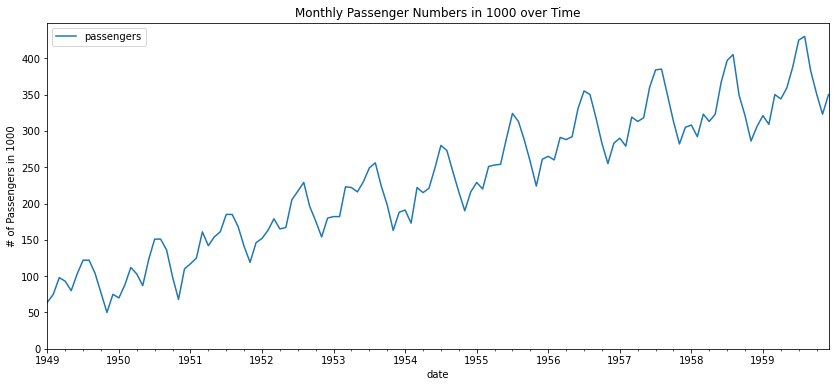

In [5]:
plot_flights(flights)

# Step 2 - Clean the Data

Fortunately we do not have to do that in case of the flights data.

# Step 3 - Extract the Timestep and the Seasonal Dummies for the whole Dataset

In [6]:
# Create a timestep variable
flights['timestep'] = list(range(len(flights)))
flights.head()

,passengers,timestep
date,,
1949-01-01,64,0
1949-02-01,75,1
1949-03-01,98,2
1949-04-01,93,3
1949-05-01,80,4


In [7]:
# pd.get_dummies(flights.index.month,
#                                  prefix='month',
#                                  drop_first=True).set_index(flights.index)

In [8]:
# Create the seasonal dummies
seasonal_dummies = pd.get_dummies(flights.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(flights.index)

flights = flights.join(seasonal_dummies)
flights.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1949-01-01,64,0,0,0,0,0,0,0,0,0,0,0,0
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0


# 4) Train-Test-Split

Fortunately not necessary for the flights data.

# 5) Model the Trend_Seasonal model

In [9]:
# Define X and y
X = flights.drop(columns=['passengers'])
y = flights['passengers']

In [10]:
# Create and fit the model
m = LinearRegression()
m.fit(X, y)

LinearRegression()

In [11]:
m.coef_

array([  2.32342172,  -4.41433081,  26.26224747,  16.84791667,
        16.34267677,  44.5647096 ,  67.87765152,  66.46332071,
        33.13989899,   1.18011364, -30.05239899,  -4.55763889])

In [12]:
# Create a new column with the predictions of the trend_seasonal model
flights['trend_seasonal'] = m.predict(X)
flights.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
date,,,,,,,,,,,,,,
1949-01-01,64,0,0,0,0,0,0,0,0,0,0,0,0,59.594697
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0,57.503788
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0,90.503788
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0,83.412879
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0,85.231061


# Plot the original data and preliminary model

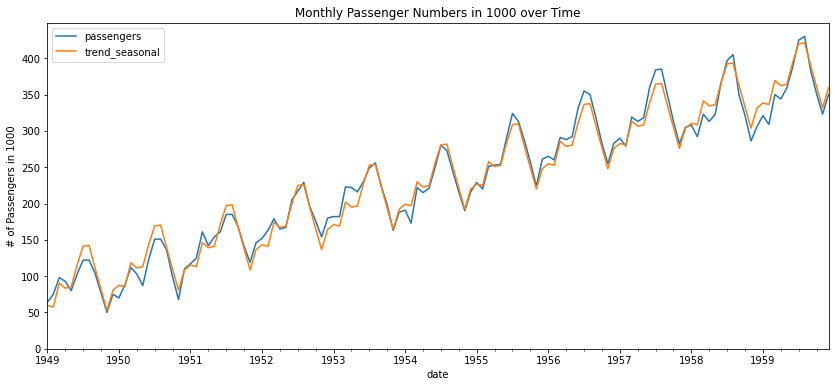

In [13]:
plot_flights(flights[['passengers', 'trend_seasonal']])

# 6) - Extract the remainder

In [14]:
# We want to extract the part of the model that the trend_seasonal is not able to explain
flights['remainder'] = flights['passengers'] - flights['trend_seasonal']

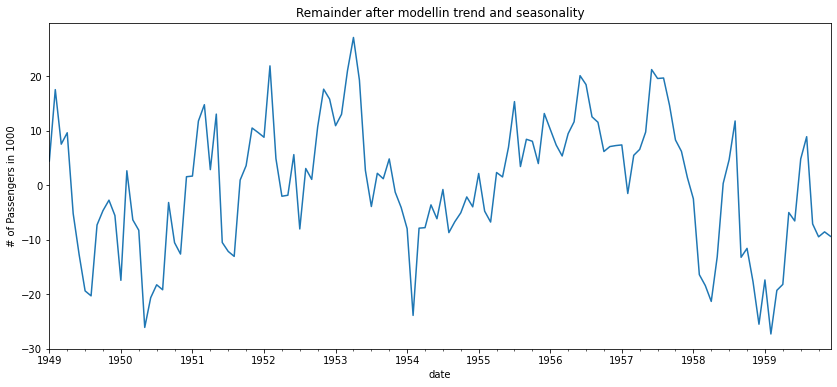

In [15]:
plot_flights(flights['remainder'], title='Remainder after modellin trend and seasonality', ylim=False)

In [16]:
flights["remainder"].std()

11.870004641031823

# 7) - Inspect the remainder to decide how many lags to include

We did this yesterday. It was one lag.

# 8) - Add the lags of the remainder to the training data

In [17]:
flights['lag1'] = flights['remainder'].shift(1)
flights.dropna(inplace=True)
flights.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1
date,,,,,,,,,,,,,,,,
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0,57.503788,17.496212,4.405303
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0,90.503788,7.496212,17.496212
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0,83.412879,9.587121,7.496212
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0,85.231061,-5.231061,9.587121
1949-06-01,103,5,0,0,0,0,1,0,0,0,0,0,0,115.776515,-12.776515,-5.231061


# 9) Run the full model

In [18]:
# Assign X
X_full = flights.drop(columns=['passengers', 'trend_seasonal', 'remainder'])
y_full = flights['passengers']

In [19]:
X_full.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
date,,,,,,,,,,,,,
1949-02-01,1,1,0,0,0,0,0,0,0,0,0,0,4.405303
1949-03-01,2,0,1,0,0,0,0,0,0,0,0,0,17.496212
1949-04-01,3,0,0,1,0,0,0,0,0,0,0,0,7.496212
1949-05-01,4,0,0,0,1,0,0,0,0,0,0,0,9.587121
1949-06-01,5,0,0,0,0,1,0,0,0,0,0,0,-5.231061


In [20]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [21]:
# Create a new predictions column
flights['predictions_full_model'] = m_full.predict(X_full)

# 10) - Plot the prediction vs passengers for the training data

In [22]:
flights.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
date,,,,,,,,,,,,,,,,,
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0,57.503788,17.496212,4.405303,60.911282
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0,90.503788,7.496212,17.496212,103.863524
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0,83.412879,9.587121,7.496212,89.170208
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0,85.231061,-5.231061,9.587121,92.577984
1949-06-01,103,5,0,0,0,0,1,0,0,0,0,0,0,115.776515,-12.776515,-5.231061,111.858054


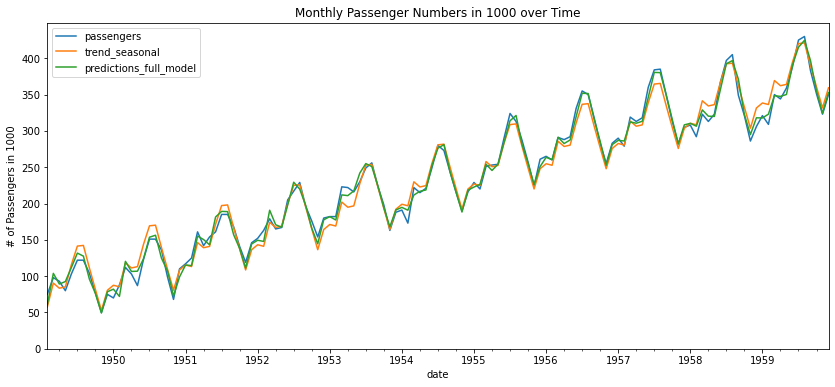

In [23]:
plot_flights(flights[['passengers', 'trend_seasonal', 'predictions_full_model']])

In [24]:
pd.DataFrame(m_full.coef_.reshape(1,13), columns=X_full.columns)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
0,2.322448,-3.263638,27.413914,18.000556,17.49629,45.719296,69.033211,67.619854,34.297405,2.338594,-28.892946,-3.397212,0.760241


-------
-------

# Is this model good?

# 10) - Evaluate our model

We want to understand how good our model would work on data it has not been trained on. We can get an estimate of that by using cross-validation.

Cross-validation so far:

- Dividing training data into subsets (folds)
- in each iteration singled out one fold as validation set
- trained on the remaining training data and evaluated the fit on the validation set.

Cross-validation for [time series](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html):

- Dividing training data into subsets (folds)
- in the first iteration, use the first fold to evaluate the second fold
- in the second iteration, use the first and thesecond fold to evaluate the third fold
- ...

In [25]:
X_full

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
date,,,,,,,,,,,,,
1949-02-01,1,1,0,0,0,0,0,0,0,0,0,0,4.405303
1949-03-01,2,0,1,0,0,0,0,0,0,0,0,0,17.496212
1949-04-01,3,0,0,1,0,0,0,0,0,0,0,0,7.496212
1949-05-01,4,0,0,0,1,0,0,0,0,0,0,0,9.587121
1949-06-01,5,0,0,0,0,1,0,0,0,0,0,0,-5.231061
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959-08-01,127,0,0,0,0,0,0,1,0,0,0,0,4.776515
1959-09-01,128,0,0,0,0,0,0,0,1,0,0,0,8.867424
1959-10-01,129,0,0,0,0,0,0,0,0,1,0,0,-7.132576


In [26]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [27]:
# Split the training data into folds
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f"""The training data for the {i+1}th iteration are the observations steps 
    {train_index}""")
    print("size of training data = {}".format(len(train_index)))
    print(f"""The validation data for the {i+1}th iteration are the observations steps
    {validation_index}""")
    print("size of validation data = {}".format(len(validation_index)))
    print('\n')
    

The training data for the 1th iteration are the observations steps 
    [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
size of training data = 26
The validation data for the 1th iteration are the observations steps
    [26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
size of validation data = 21


The training data for the 2th iteration are the observations steps 
    [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
size of training data = 47
The validation data for the 2th iteration are the observations steps
    [47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]
size of validation data = 21


The training data for the 3th iteration are the observations steps 
    [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54

In [28]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full) 

In [29]:
# Do the cross validation
result = cross_val_score(estimator=m_full, X=X_full, y=y_full,
                         cv=time_series_split)
result

array([0.82727944, 0.82914029, 0.95730085, 0.9419188 , 0.92308191])

In [30]:
result.mean()

0.89574425865198

In [31]:
result_ordinary_cv = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=5)
result_ordinary_cv

array([0.8366566 , 0.8803288 , 0.96908224, 0.97002703, 0.90913402])

In [32]:
result_ordinary_cv.mean()

0.9130457383359738

# 12) - Test your model

In [33]:
flights_test = pd.read_csv('flights_test.csv', index_col=0, parse_dates=True)
flights_test.head()

,passengers
date,
1960-01-01,357
1960-02-01,341
1960-03-01,358
1960-04-01,382
1960-05-01,388


In [34]:
flights_test.tail()

,passengers
date,
1960-08-01,451
1960-09-01,406
1960-10-01,382
1960-11-01,341
1960-12-01,366


First the transformations necessary for the trend-seasonal model test

In [35]:
flights.tail(2)

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
date,,,,,,,,,,,,,,,,,
1959-11-01,323,130,0,0,0,0,0,0,0,0,0,1,0,331.587121,-8.587121,-9.496212,324.309311
1959-12-01,350,131,0,0,0,0,0,0,0,0,0,0,1,359.405303,-9.405303,-8.587121,352.818620


In [36]:
# Last timestep of the training data
last_train_timestep = flights['timestep'][-1]

In [37]:
last_train_timestep

131

In [38]:
# Create a timestep for the model
flights_test['timestep'] = list(range(last_train_timestep + 1, len(flights_test) + last_train_timestep + 1))
flights_test.head()

,passengers,timestep
date,,
1960-01-01,357,132
1960-02-01,341,133
1960-03-01,358,134
1960-04-01,382,135
1960-05-01,388,136


In [39]:
seasonal_dummies = pd.get_dummies(flights_test.index.month, 
                                  prefix='month', 
                                 drop_first=True).set_index(flights_test.index)

flights_test = flights_test.join(seasonal_dummies)
flights_test.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1960-01-01,357,132,0,0,0,0,0,0,0,0,0,0,0
1960-02-01,341,133,1,0,0,0,0,0,0,0,0,0,0
1960-03-01,358,134,0,1,0,0,0,0,0,0,0,0,0
1960-04-01,382,135,0,0,1,0,0,0,0,0,0,0,0
1960-05-01,388,136,0,0,0,1,0,0,0,0,0,0,0


In [40]:
# Assign X_test
X_test = flights_test.drop(columns=['passengers'])

In [41]:
X_test

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,
1960-01-01,132,0,0,0,0,0,0,0,0,0,0,0
1960-02-01,133,1,0,0,0,0,0,0,0,0,0,0
1960-03-01,134,0,1,0,0,0,0,0,0,0,0,0
1960-04-01,135,0,0,1,0,0,0,0,0,0,0,0
1960-05-01,136,0,0,0,1,0,0,0,0,0,0,0
1960-06-01,137,0,0,0,0,1,0,0,0,0,0,0
1960-07-01,138,0,0,0,0,0,1,0,0,0,0,0
1960-08-01,139,0,0,0,0,0,0,1,0,0,0,0
1960-09-01,140,0,0,0,0,0,0,0,1,0,0,0


In [42]:
m.coef_

array([  2.32342172,  -4.41433081,  26.26224747,  16.84791667,
        16.34267677,  44.5647096 ,  67.87765152,  66.46332071,
        33.13989899,   1.18011364, -30.05239899,  -4.55763889])

In [43]:
# Predict trend and seasonality
flights_test['trend_seasonal'] = m.predict(X_test)
flights_test.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
date,,,,,,,,,,,,,,
1960-01-01,357,132,0,0,0,0,0,0,0,0,0,0,0,366.286364
1960-02-01,341,133,1,0,0,0,0,0,0,0,0,0,0,364.195455
1960-03-01,358,134,0,1,0,0,0,0,0,0,0,0,0,397.195455
1960-04-01,382,135,0,0,1,0,0,0,0,0,0,0,0,390.104545
1960-05-01,388,136,0,0,0,1,0,0,0,0,0,0,0,391.922727


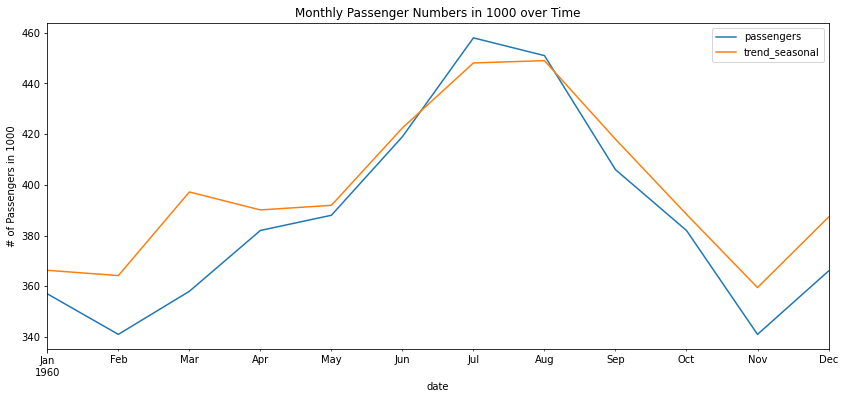

In [44]:
plot_flights(flights_test[['passengers', 'trend_seasonal']], ylim=False)

In [45]:
# Calculate the remainder for the test set
flights_test['remainder'] = flights_test['passengers'] - flights_test['trend_seasonal']

In [46]:
# Create the lagged variable
flights_test['lag1'] = flights_test['remainder'].shift(1)

In [47]:
# Assign X_full
X_full = flights_test.drop(columns=['passengers', 'trend_seasonal', 'remainder'])

In [48]:
X_full.head() # Contains a NaN for the first value of lag1

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
date,,,,,,,,,,,,,
1960-01-01,132,0,0,0,0,0,0,0,0,0,0,0,NaN
1960-02-01,133,1,0,0,0,0,0,0,0,0,0,0,-9.286364
1960-03-01,134,0,1,0,0,0,0,0,0,0,0,0,-23.195455
1960-04-01,135,0,0,1,0,0,0,0,0,0,0,0,-39.195455
1960-05-01,136,0,0,0,1,0,0,0,0,0,0,0,-8.104545


Filling in the missing value from the beginning of the test lag.

In [49]:
X_full.loc['1960-01-01', 'lag1'] = flights.loc['1959-12-01', 'remainder']

In [50]:
X_full.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
date,,,,,,,,,,,,,
1960-01-01,132,0,0,0,0,0,0,0,0,0,0,0,-9.405303
1960-02-01,133,1,0,0,0,0,0,0,0,0,0,0,-9.286364
1960-03-01,134,0,1,0,0,0,0,0,0,0,0,0,-23.195455
1960-04-01,135,0,0,1,0,0,0,0,0,0,0,0,-39.195455
1960-05-01,136,0,0,0,1,0,0,0,0,0,0,0,-8.104545


In [51]:
# Create the predictions
flights_test['predictions_full_model'] = m_full.predict(X_full)

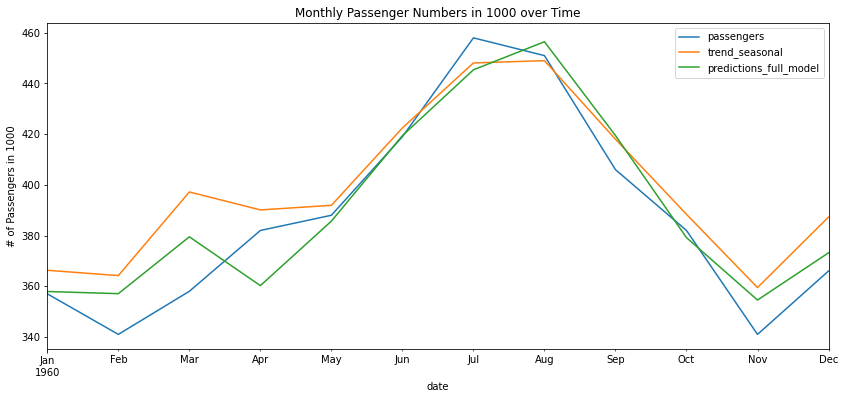

In [52]:
plot_flights(flights_test[['passengers', 'trend_seasonal', 'predictions_full_model']], ylim=False)

In [53]:
# Create the complete dataset and plot it
flights_full = flights[['passengers', 'trend_seasonal', 'predictions_full_model']].append(flights_test[['passengers', 'trend_seasonal', 'predictions_full_model']])

In [54]:
flights_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 1949-02-01 to 1960-12-01
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   passengers              143 non-null    int64  
 1   trend_seasonal          143 non-null    float64
 2   predictions_full_model  143 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 4.5 KB


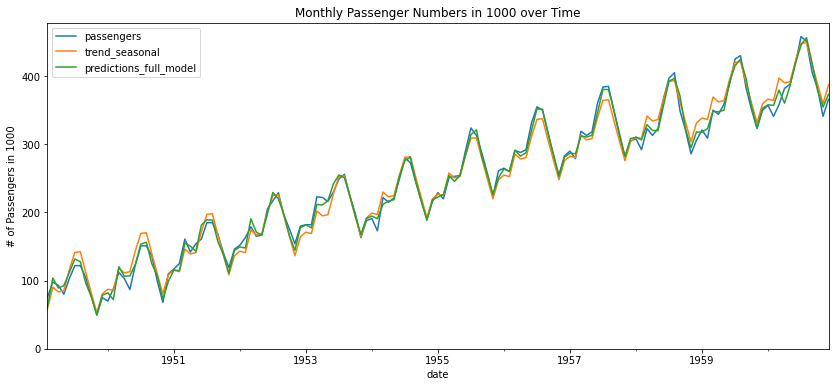

In [55]:
plot_flights(flights_full)

In [56]:
m_full.score(X_full, flights_test['passengers'])

0.8932731911942129

# 13) - Predict the future

So far we have just predicted data that we already had (train and test). We have not actually made any predictions for the future.

In [57]:
flights_test.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
date,,,,,,,,,,,,,,,,,
1960-01-01,357,132,0,0,0,0,0,0,0,0,0,0,0,366.286364,-9.286364,NaN,357.916266
1960-02-01,341,133,1,0,0,0,0,0,0,0,0,0,0,364.195455,-23.195455,-9.286364,357.065499
1960-03-01,358,134,0,1,0,0,0,0,0,0,0,0,0,397.195455,-39.195455,-23.195455,379.491242
1960-04-01,382,135,0,0,1,0,0,0,0,0,0,0,0,390.104545,-8.104545,-39.195455,360.236483
1960-05-01,388,136,0,0,0,1,0,0,0,0,0,0,0,391.922727,-3.922727,-8.104545,385.691237


In [58]:
print(flights_test.info())

print(flights.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 1960-01-01 to 1960-12-01
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   passengers              12 non-null     int64  
 1   timestep                12 non-null     int64  
 2   month_2                 12 non-null     uint8  
 3   month_3                 12 non-null     uint8  
 4   month_4                 12 non-null     uint8  
 5   month_5                 12 non-null     uint8  
 6   month_6                 12 non-null     uint8  
 7   month_7                 12 non-null     uint8  
 8   month_8                 12 non-null     uint8  
 9   month_9                 12 non-null     uint8  
 10  month_10                12 non-null     uint8  
 11  month_11                12 non-null     uint8  
 12  month_12                12 non-null     uint8  
 13  trend_seasonal          12 non-null     float64
 14  remainder               

In [59]:
# Combine train and test data
flights_combined = flights.append(flights_test)
flights_combined.tail()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
date,,,,,,,,,,,,,,,,,
1960-08-01,451,139,0,0,0,0,0,0,1,0,0,0,0,449.013636,1.986364,9.895455,456.466478
1960-09-01,406,140,0,0,0,0,0,0,0,1,0,0,0,418.013636,-12.013636,1.986364,419.453666
1960-10-01,382,141,0,0,0,0,0,0,0,0,1,0,0,388.377273,-6.377273,-12.013636,379.173933
1960-11-01,341,142,0,0,0,0,0,0,0,0,0,1,0,359.468182,-18.468182,-6.377273,354.549835
1960-12-01,366,143,0,0,0,0,0,0,0,0,0,0,1,387.286364,-21.286364,-18.468182,373.176016


In [60]:
# Re-train the model on the whole dataset
X_combined = flights_combined.drop(columns=['passengers', 'trend_seasonal', 'remainder', 'predictions_full_model'])
y_combined = flights_combined['passengers']

In [61]:
X_combined.isna().sum()

timestep    0
month_2     0
month_3     0
month_4     0
month_5     0
month_6     0
month_7     0
month_8     0
month_9     0
month_10    0
month_11    0
month_12    0
lag1        1
dtype: int64

Fill in the missing value from the beginning of the test set.

In [62]:
X_combined.loc['1960-01-01', 'lag1'] = flights.loc['1959-12-01', 'remainder']

In [63]:
X_combined.tail(1)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
date,,,,,,,,,,,,,
1960-12-01,143,0,0,0,0,0,0,0,0,0,0,1,-18.468182


In [64]:
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

### We are going to create a single future step data.

In [65]:
# What is the first date in the future? --> 1961-01-01
timestep = flights_combined['timestep'].max() + 1
months = [0] * 11 # dummy code for Jan
lag = flights_combined.loc['1960-12-01', 'remainder'] # taking the last remainder 

In [66]:
timestep, months, lag

(144, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], -21.28636363636383)

In [67]:
X_future = []

X_future.append(timestep)
X_future

[144]

In [68]:
X_future.extend(months)
X_future

[144, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [69]:
X_future.append(lag)
X_future

[144, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -21.28636363636383]

In [70]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns

X_future

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
0,144,0,0,0,0,0,0,0,0,0,0,0,-21.286364


In [71]:
# Prediction for 1961-01-01

m_combined.predict(X_future)

array([376.10581815])

In [72]:
# How does this look like for 1961-02-01?
timestep = flights_combined['timestep'].max() + 1
months = [1] + [0]*10
lag = 0 
# This is too far in the future to calculate the lag; 
# our best guess will be a lag of 0 (for the last step, we had
# used the remainder of the end of the combined dataframe.)

In [73]:
X_future_2 = pd.DataFrame([[timestep] + months + [lag]])
X_future_2.columns = X_combined.columns
X_future_2

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
0,144,1,0,0,0,0,0,0,0,0,0,0,0


In [74]:
# Prediction for 1961-02-01

m_combined.predict(X_future_2)

array([387.48402755])

The prediction for 1961-02-01 was just the prediction of trend and seasonality.

# THE BELOW IS JUST A REMINDER OF YESTERDAY'S AR LESSON

## Let's look at Correlation and Autocorrelation

In [75]:
# Let's focus on the remainder
r = flights_combined[['remainder']].copy()


In [76]:
# Create lags
r['lag1'] = r['remainder'].shift(1)
r['lag2'] = r['remainder'].shift(2)
r.head()

,remainder,lag1,lag2
date,,,
1949-02-01,17.496212,NaN,NaN
1949-03-01,7.496212,17.496212,NaN
1949-04-01,9.587121,7.496212,17.496212
1949-05-01,-5.231061,9.587121,7.496212
1949-06-01,-12.776515,-5.231061,9.587121


In [77]:
# Autcorrelation
round(r.corr(), 2)

,remainder,lag1,lag2
remainder,1.00,0.75,0.57
lag1,0.75,1.00,0.74
lag2,0.57,0.74,1.00


In [78]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

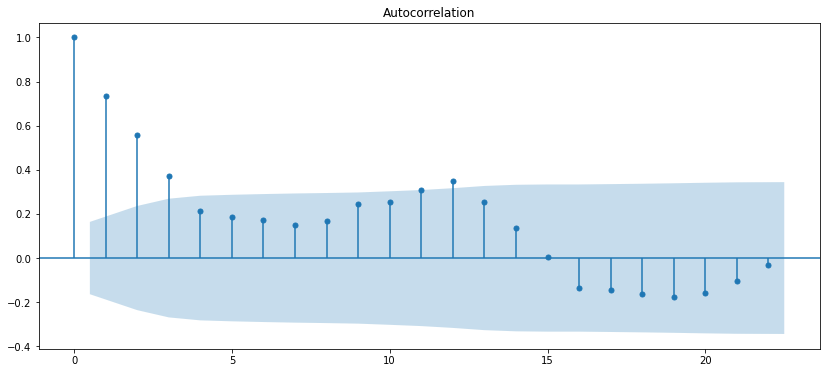

In [79]:
plot_acf(r['remainder']);

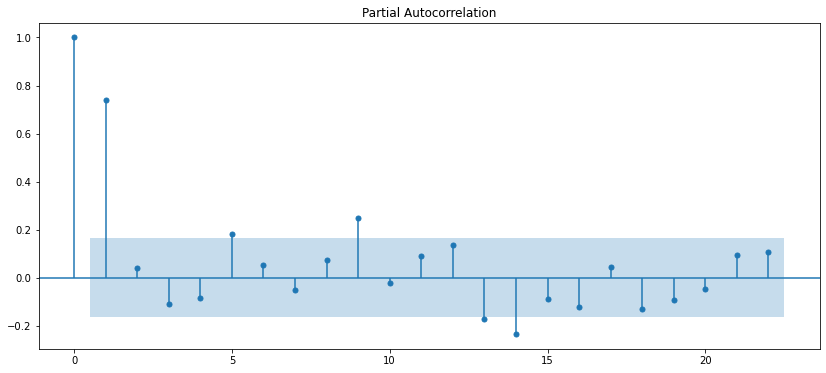

In [80]:
plot_pacf(r['remainder']);

# What is Partial Autocorrelation

The partial autocorrelation between remainder and lag2 would be the linear regression coefficient of lag2 in a linear regression of lag1 and lag2 on the remainder.

In [81]:
r.dropna(inplace=True)

m_pacf = LinearRegression() 
m_pacf.fit(r[['lag1', 'lag2']], r['remainder'])

LinearRegression()

In [82]:
m_pacf.coef_

array([0.72327721, 0.03918208])

Equivalent

In [83]:
m_lag1 = LinearRegression()
m_lag1.fit(r[['lag1']], r['remainder'])

LinearRegression()

In [84]:
m_lag1.coef_

array([0.7523811])

In [85]:
r['pred_lag1'] = m_lag1.predict(r[['lag1']])

In [86]:
r['resid_lag1'] = r['remainder'] - r['pred_lag1']

In [87]:
round(r.corr(), 2)

,remainder,lag1,lag2,pred_lag1,resid_lag1
remainder,1.00,0.75,0.57,0.75,0.67
lag1,0.75,1.00,0.74,1.00,-0.00
lag2,0.57,0.74,1.00,0.74,0.03
pred_lag1,0.75,1.00,0.74,1.00,-0.00
resid_lag1,0.67,-0.00,0.03,-0.00,1.00


<AxesSubplot:xlabel='date'>

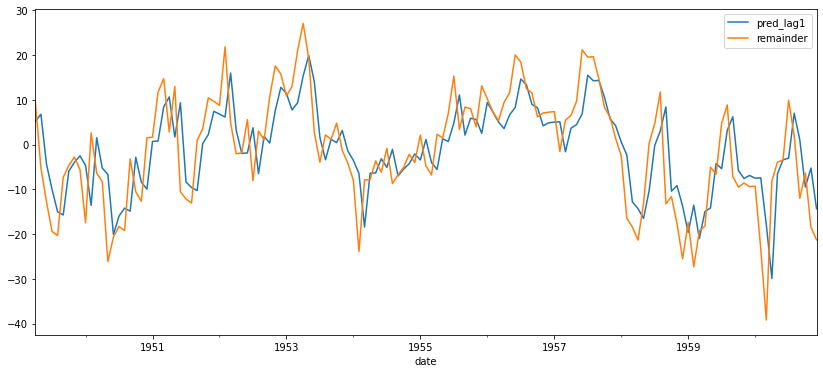

In [88]:
r[['pred_lag1', 'remainder']].plot()